In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Importing all packages from the fastai.vision library
import torch
import torchvision
from fastai.vision import *


In [3]:
# Creating a list of the classes of images to be classified
classes = ['daffodil', 'rose', 'tulip', 'iris', 'daisy', 'hyacinth',
           'oriental_lily', 'dahlia', 'orchid', 'hydrangea']

In [4]:

torch.cuda.is_available()

True

In [5]:
# Defining location path for the dataset images
path = Path('data/flowers')

In [5]:
# Checking all images that were downloaded can be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

daffodil


rose


tulip


iris


daisy


hyacinth


oriental_lily


dahlia


orchid


hydrangea


In [6]:
# setting random seed to 42 - the answer to life, the universe and everything
np.random.seed(42)
# Create from imagenet style dataset/databunch object in path with training set 
# and validation set with an 80:20 split with all images normalised
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
# Confirming the classes in the data object
data.classes

['daffodil',
 'dahlia',
 'daisy',
 'hyacinth',
 'hydrangea',
 'iris',
 'orchid',
 'oriental_lily',
 'rose',
 'tulip']

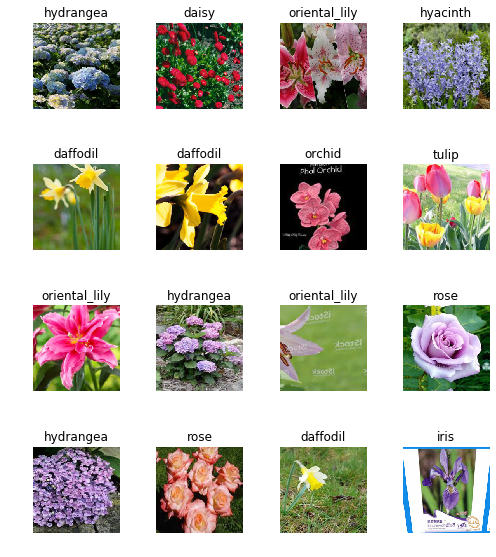

In [8]:
# Showing a sample of images of the batch 
data.show_batch(rows=4, figsize=(7,8))

In [9]:
# Confirming the class names, number of classes, length of the training and 
# validation datasets
# if done correctly with no issues with the images we should get a length of 
# 960 for the training dataset and 240 for the validation dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['daffodil',
  'dahlia',
  'daisy',
  'hyacinth',
  'hydrangea',
  'iris',
  'orchid',
  'oriental_lily',
  'rose',
  'tulip'],
 10,
 1483,
 370)

In [10]:
# instantiate the cnn_learner model for our data, with resnet34, 
# and error rate as the metric
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Andrew Chisholm/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:16<00:00, 5.20MB/s]


In [11]:
# Fitting our model to the data with 4 epochs

learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.107095,0.450121,0.132432,00:43
1,1.175173,0.341774,0.091892,00:42
2,0.792106,0.304856,0.081081,00:38
3,0.578386,0.306209,0.081081,00:39


In [12]:
# Saving this version of our model
learn.save('stage_1')

In [13]:
# This is unfreezing the initial layers weights to train the model at a lower level
# than before.
# The initial layers are mostly used for understanding low-level features like 
# curves, lines, shapes, patterns. When we use pre-trained models they are trained 
# for identifying these features on a large dataset of images like Imagenet(1000 categories).

learn.unfreeze()

In [14]:
# Finding the learning rate of the model to help identify a parameter where the 
# model can be improved
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


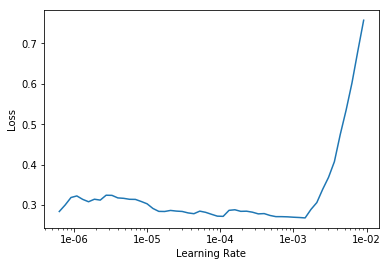

In [15]:
# Plotting the learning rate
learn.recorder.plot()

In [16]:
# Re-training the unfrozen model with 4 epochs and lr from 3e-4 to 3e-3
learn.fit_one_cycle(6, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.320920,0.948997,0.175676,00:43
1,0.520269,1.184232,0.189189,00:41
2,0.520603,0.516642,0.137838,00:41
3,0.425022,0.262808,0.081081,00:42
4,0.312524,0.258662,0.081081,00:42
5,0.224503,0.247377,0.081081,00:42


In [17]:
# Saving this version of the model
learn.save('stage_2')


## Interpretation

In [18]:
# Loading the stage_2 version of the model
learn.load('stage_2')

Learner(data=ImageDataBunch;

Train: LabelList (1483 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
daffodil,daffodil,daffodil,daffodil,daffodil
Path: data\flowers;

Valid: LabelList (370 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dahlia,daisy,orchid,tulip,daisy
Path: data\flowers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [19]:
# Createing an instance of ClassificationInterpretation. 
interp = ClassificationInterpretation.from_learner(learn)

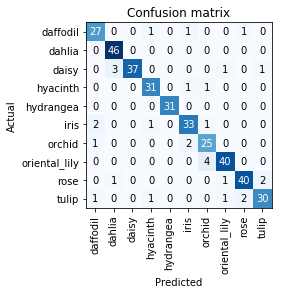

In [20]:
# Plotting the confusion matrix 
interp.plot_confusion_matrix()

In [21]:
# Calculating the top losses and indexing them
losses,idxs = interp.top_losses()
# Checking that the lengths of the validation dataset, all lose values, and indexes
# are equal
len(data.valid_ds)==len(losses)==len(idxs)

True

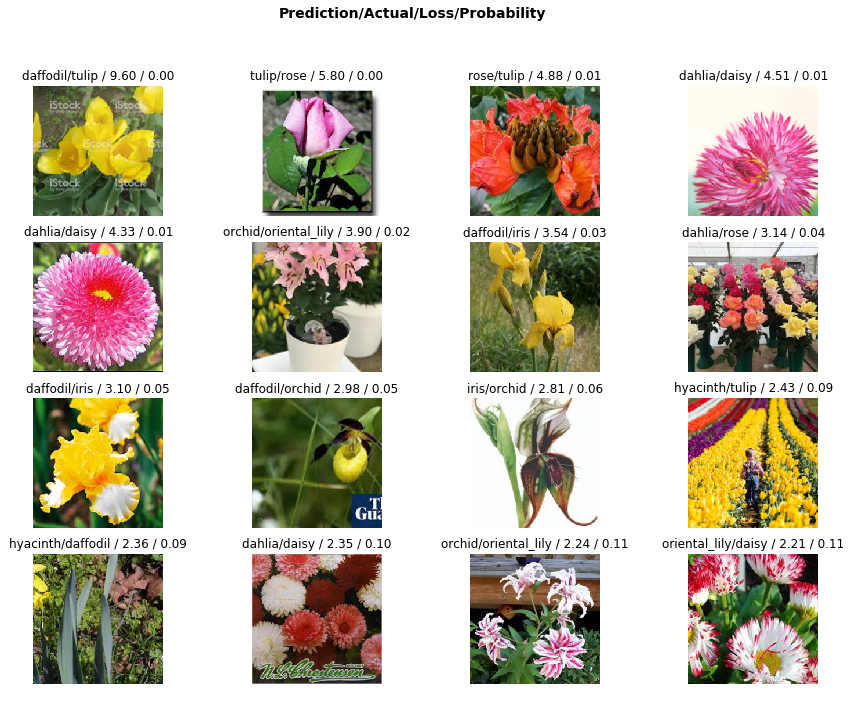

In [22]:
# Plotting the top 16 losses
interp.plot_top_losses(16, figsize=(15,11))